## **4.2 Model-Based Collaborative Filtering**

Model-based recommender systems often have a number of advantages over neighborhood-based methods:
1. **Space-efficiency**: Typically, the size of the learned model is much smaller than the original ratings matrix. Thus, the space requirements are often quite low. On the other hand, a user-based neighborhood method might have $O(m^2)$ space complexity, where $m$ is the number of users. An item-based method will have $O(n^2)$ space complexity.
   
2. **Training speed and prediction speed**: One problem with neighborhood-based methods is that the pre-processing stage is quadratic in either the number of users or the number of items. Model-based systems are usually much faster in the preprocessing phase of constructing the trained model. In most cases, the compact and summarized model can be used to make predictions efficiently.
   
3. **Avoiding overfitting**: Overfitting is a serious problem in many machine learning algorithms, in which the prediction is overly influenced by random artifacts in the data. This problem is also encountered in classification and regression models. The sum- marization approach of model-based methods can often help in avoiding overfitting. Furthermore, regularization methods can be used to make these models robust.

### **4.2.1 Matrix Factorisation**

Matrix factorisation is a class of collaborative filtering models. Specifically, the model factorises the user-item interaction matrix (i.e. rating matrix) into the product of two lower-rank matrices, capturing the low-rank structure of the user-item interactions. 

Let $\mathbf{Y} \in \mathbb{R}^{m\times n}$ denote the interaction matrix with $m$ users and $n$ items, and the value of $\mathbf{Y}$ represent explicit ratings. The user-item interaction will be factorised into a user latent matrix $\mathbf{P}\in \mathbb{R}^{m \times k}$ and an item latent matrix $\mathbf{Q} \in \mathbb{R}^{n \times k}$, where $k<<m,n$ is the latent factor size.

 Let $p_{u}$ denote the $u^{th}$ row of $\mathbf{P}$ and $q_{i}$ denote the $i^{th}$ row of $\mathbf{Q}$. 
 
 - For a given item $i$, the elements of $q_{i}$ measure the extent to which the item possesses those characteristics such as the genres and languages of a movie. 
 
 - For a given user $u$, the elements of $p_{u}$ measure the extent of interest the user has in items’ corresponding characteristics. 
 
 These latent factors might measure obvious dimensions as mentioned in those examples or are completely uninterpretable. The predicted ratings can be estimated by, 

 $$ \hat{\mathbf{Y}} = \mathbf{P}\mathbf{Q}^{T}$$

 where  $\hat{\mathbf{Y}} \in \mathbb{R}^{m \times n}$ is the predicted rating matrix which has the same shape as $\mathbf{Y}$.


---

### **4.2.2 Singular Value Decomposition (SVD)**

For any real matrix $ M \in \mathbb{R}^{m \times n} $, we can decompose $M$ into three matrices (a rotation, followed by a rescaling followed by another rotation - rescaling can include a flip too) such as:

$$ M = U \Sigma V^T $$

where $ U \in \mathbb{R}^{m \times m} $ has orthonormal columns, $ \Sigma \in \mathbb{R}^{m \times n} $ is a matrix containing $D = \mathrm{min}(m,n)$ singular values $ \sigma_i \geq 0 $ on the main diagonal, and $ V \in \mathbb{R}^{n \times n} $ has orthonormal columns and rows.
When $ \Sigma \in \mathbb{R}^{m \times k} $ where $k<<m,n$ we talk about $\textit{truncated}$ SVD.


---

<img src="https://upload.wikimedia.org/wikipedia/commons/b/bb/Singular-Value-Decomposition.svg" width="500" height="500" />

(https://www.youtube.com/watch?v=CpD9XlTu3ys)

---


Therefore, we can view the recommender problem as one of matrix completion, in which we wish to predict all the missing entries of $\mathbf{Y}$. 

We can formulate this as the following optimization problem:

$$\mathcal{L}(\mathbf{\hat{Y}}) = \sum_{ij:Y_{ij} \neq ?} (\hat{Y}_{ij} - Y_{ij})^{2} = ||\mathbf{\hat{Y}} - \mathbf{Y}||^{2}$$

If we observe all the $Y_{ij}$ entries, we can find the optima $\hat{\mathbf{Y}}$ using $\mathbf{SVD}$. 

When $\mathbf{Y}$ has missing entries, the objective function is no longer convex, and does not have a unique optimum (do you know why?). We can fit this using:
- **Alternating least squares (ALS)**, where we estimate $\mathbf{Q}$ given $\mathbf{P}$ and then estimate $\mathbf{P}$ given $\mathbf{Q}$. 

- **$\mathbf{SGD}$**. (the one we are going to be using)

In practice, it is important to also allow for user-specific $b_{u}$ and item-specific baselines $c_{i}$, and also $\mu$ the global mean of the entire rating matrix. To do so, we introduce biases in the optimisation problem. Specifically, the **predicted rating user** gives to item  is calculated by,

- Matrix Decomposition:

$$\hat{y}_{ui} = p_{u}q_{i}^{T} + \mu + b_{u} + c_{i} $$

- SVD:

$$\hat{y}_{ui} = U\Sigma V^{T} + \mu + b_{u} + c_{i} $$

This can capture the fact that some users might always tend to give low ratings and others may give high ratings; in addition, some items (e.g., very popular movies) might have unusually high ratings.

In addition, we can add some $\ell_{2}$ regularisation to the parameters to get the objective, 

$$\mathcal{L}(\theta) = \sum_{ij:Y_{ij} \neq ?} (y_{ij} - \hat{y}_{ij})^{2} + \frac{\lambda}{2}(b^{2}_{u} + c_{i}^{2} + ||p_{u}||^{2} + ||q_{i}||^{2})$$

where $\lambda$ denotes the regularisation rate. The regularising term is used to avoid over-fitting by penalising the magnitude of the parameters. 

We can optimize this using SGD by sampling a random $(u, i)$ entry from the set of observed values, and performing the following updates:

$$b_{u} = b_{u} + \eta(e_{ui} - \lambda b_{u})$$

$$c_{i} = c_{i} + \eta(e_{ui} - \lambda c_{i})$$

$$\mathbf{p}_{u} = \mathbf{p}_{u} + \eta(e_{ui}\mathbf{q}_{i} - \lambda \mathbf{p}_{u})$$

$$\mathbf{q}_{i} = \mathbf{q}_{i} + \eta(e_{ui}\mathbf{p}_{u} - \lambda \mathbf{q}_{i} )$$

where $e_{ui} = y_{ui} − \hat{y}_{ui}$ is the error term, and $\eta >0$ is the learning rate. 

This approach was first proposed by Simon Funk, who was one of the first to do well in the early days of the Netflix competition (https://sifter.org/~simon/journal/20061211.html)

---

Let us remember the RMSE (root-mean-square error) measure, which is commonly used to measure the differences between rating scores predicted by the model and the actually observed ratings (ground truth) (Gunawardana and Shani, 2015). RMSE is defined as:

$$ RMSE = \sqrt{\frac{1}{|\mathcal{T}|}\sum_{(u,i)\in \mathcal{T}} (Y_{ui} - \hat{Y}_{ui})^{2}} $$

where $\mathcal{T}$ is the set consisting of pairs of users and items that you want to evaluate on, and $|\mathcal{T}|$ is the size of the set. 

---

### **Example: MovieLens**

Now suppose we apply PMF to the MovieLens-1M dataset with 6040 users, 3706 movies, and 1,000,209 ratings. 

For simplicity, we fit this using SVD applied to the dense ratings matrix, where we replace missing values with 0. (This is just a simple approximation to keep the demo code simple.) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = "./collaborative_based/memory/ml-latest-small/"

In [2]:
ratings_df = pd.read_csv(DATA_DIR + "ratings.csv")
movies_df = pd.read_csv(DATA_DIR + "movies.csv")

FileNotFoundError: [Errno 2] No such file or directory: './collaborative_based/memory/ml-latest-small/ratings.csv'

In [ ]:
ratings_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [ ]:
np.sort(ratings_df["rating"].unique())

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [ ]:
movies_df.columns

Index(['movieId', 'title', 'genres'], dtype='object')

Compute the ratings-matrix

In [ ]:
mu = 3

In [ ]:
R_df = ratings_df.pivot(index="userId", columns="movieId", values="rating").fillna(mu)

R_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
4,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
5,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


In [ ]:
R = R_df.to_numpy()

# center the ratings
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

print(R.shape)
print(np.count_nonzero(R))

(610, 9724)
5931640


Scipy and Numpy both have functions to do the singular value decomposition. 

I'm going to use the Scipy function `svds` because it let's me choose how many latent factors I want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [ ]:
from scipy.sparse.linalg import svds
import math

U, sigma, Vt = svds(R_demeaned, k=50)
sigma = np.diag(sigma)

In [ ]:
from numpy.linalg import matrix_rank

matrix_rank(R_demeaned)

610

In [ ]:
latents = [3, 10, 20, 30, 40, 50, 150, 300]
rmse_errors = []
for latent_dim in latents:
    U, sigma, Vt = svds(R_demeaned, k=latent_dim)
    sigma = np.diag(sigma)
    Rpred = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    Rpred[Rpred < 0] = 0
    Rpred[Rpred > 5] = 5
    MSE = np.square(np.subtract(R, Rpred)).mean()
    RMSE = math.sqrt(MSE)
    rmse_errors.append(RMSE)

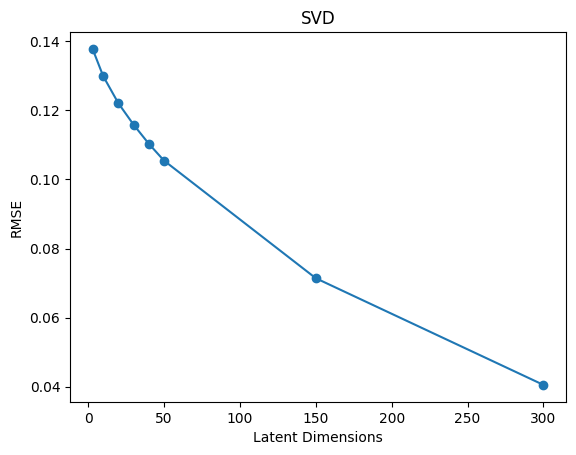

In [ ]:
import seaborn as sns

plt.xlabel("Latent Dimensions")
plt.ylabel("RMSE")
plt.title("SVD")
plt.plot(latents, rmse_errors, "o-")
plt.show()

In [ ]:
Rpred_df = pd.DataFrame(Rpred)
Rpred_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,4.113887,2.991394,3.977271,3.014018,2.996851,4.032697,3.036739,2.989184,2.991469,2.934997,...,2.999383,3.000025,2.998742,2.998742,2.999383,2.998742,2.999383,2.999383,2.999383,2.999066
1,2.970751,3.004656,2.921116,3.019859,3.024215,2.901931,2.959077,2.981246,2.985186,3.102985,...,3.006477,3.000247,3.012706,3.012706,3.006477,3.012706,3.006477,3.006477,3.006477,3.025560
2,2.948330,3.013328,2.937705,3.003137,2.962295,3.047376,2.913775,2.976536,2.962972,2.902675,...,3.001223,3.000446,3.001999,3.001999,3.001223,3.001999,3.001223,3.001223,3.001223,2.993162
3,3.034389,3.028468,3.011799,3.041744,3.045418,2.991794,3.020722,2.995950,3.012849,3.038418,...,3.000365,2.999866,3.000864,3.000864,3.000365,3.000864,3.000365,3.000365,3.000365,2.999136
4,3.985156,3.172021,3.094408,2.947081,3.098795,3.032509,3.173364,3.096320,2.967677,2.732633,...,3.003512,2.999246,3.007779,3.007779,3.003512,3.007779,3.003512,3.003512,3.003512,2.978596


### Making Predictions from the Decomposed Matrices

I now have everything I need to make movie ratings predictions for every user. I can do it all at once by following the math and matrix multiply $U$, $\Sigma$, and $V^{T}$ back to get the rank $k=50$ approximation of $\mathbf{Y}$.

I also need to add the user means back to get the actual star ratings prediction.

In [ ]:
# Y = U Sigma Vt + mean
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(
    -1, 1
)

all_user_predicted_ratings[all_user_predicted_ratings < 0] = 0
all_user_predicted_ratings[all_user_predicted_ratings > 5] = 5

preds_df = pd.DataFrame(all_user_predicted_ratings, columns=R_df.columns)
preds_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,4.113887,2.991394,3.977271,3.014018,2.996851,4.032697,3.036739,2.989184,2.991469,2.934997,...,2.999383,3.000025,2.998742,2.998742,2.999383,2.998742,2.999383,2.999383,2.999383,2.999066
1,2.970751,3.004656,2.921116,3.019859,3.024215,2.901931,2.959077,2.981246,2.985186,3.102985,...,3.006477,3.000247,3.012706,3.012706,3.006477,3.012706,3.006477,3.006477,3.006477,3.025560
2,2.948330,3.013328,2.937705,3.003137,2.962295,3.047376,2.913775,2.976536,2.962972,2.902675,...,3.001223,3.000446,3.001999,3.001999,3.001223,3.001999,3.001223,3.001223,3.001223,2.993162
3,3.034389,3.028468,3.011799,3.041744,3.045418,2.991794,3.020722,2.995950,3.012849,3.038418,...,3.000365,2.999866,3.000864,3.000864,3.000365,3.000864,3.000365,3.000365,3.000365,2.999136
4,3.985156,3.172021,3.094408,2.947081,3.098795,3.032509,3.173364,3.096320,2.967677,2.732633,...,3.003512,2.999246,3.007779,3.007779,3.003512,3.007779,3.003512,3.003512,3.003512,2.978596


### Making Movie Recommendations
Finally, it's time. With the predictions matrix for every user, I can build a function to recommend movies for any user. All I need to do is return the movies with the highest predicted rating that the specified user hasn't already rated. Though I didn't use actually use any explicit movie content features (such as genre or title), I'll merge in that information to get a more complete picture of the recommendations.

I'll also return the list of movies the user has already rated, for the sake of comparison.

In [ ]:
def recommend_movies(
    preds_df, userID, movies_df, original_ratings_df, num_recommendations=5
):

    # Get and sort the user's predictions
    user_row_number = userID - 1
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(
        ascending=False
    )

    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = user_data.merge(
        movies_df, how="left", left_on="movieId", right_on="movieId"
    ).sort_values(["rating"], ascending=False)

    print("User {0} has already rated {1} movies.".format(userID, user_full.shape[0]))
    print(
        "Recommending highest {0} predicted ratings movies not already rated.".format(
            num_recommendations
        )
    )

    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (
        movies_df[~movies_df["movieId"].isin(user_full["movieId"])]
        .merge(
            pd.DataFrame(sorted_user_predictions).reset_index(),
            how="left",
            left_on="movieId",
            right_on="movieId",
        )
        .rename(columns={user_row_number: "Predictions"})
        .sort_values("Predictions", ascending=False)
        .iloc[:num_recommendations, :-1]
    )

    return user_full, recommendations

In [ ]:
already_rated, predictions = recommend_movies(preds_df, 29, movies_df, ratings_df)
df = already_rated[["movieId", "title", "genres"]].copy()
# df.head(5)
predictions.head(5)

User 29 has already rated 81 movies.
Recommending highest 5 predicted ratings movies not already rated.


,movieId,title,genres
2956,4022,Cast Away (2000),Drama
245,288,Natural Born Killers (1994),Action|Crime|Thriller
1756,2395,Rushmore (1998),Comedy|Drama
2870,3916,Remember the Titans (2000),Drama
193,231,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy


These look like pretty good recommendations. It's also good to see that, though I didn't actually use the genre of the movie as a feature, the truncated matrix factorization features "picked up" on the underlying tastes and preferences of the user. I've recommended some film-noirs, crime, drama, and war movies - all of which were genres of some of this user's top rated movies.

In [ ]:
nusers = 20
nitems = 20


plt.figure(figsize=(10, 10))
plt.imshow(R[:nusers, :nitems], cmap="jet")
plt.xlabel("item")
plt.ylabel("user")
plt.title("True ratings")
plt.colorbar()


plt.figure(figsize=(10, 10))
plt.imshow(Rpred[:nusers, :nitems], cmap="jet")
plt.xlabel("item")
plt.ylabel("user")
plt.title("Predicted ratings")
plt.colorbar()

MSE = np.square(np.subtract(R[:nusers, :nitems], Rpred[:nusers, :nitems]))

plt.figure(figsize=(10, 10))
plt.imshow(MSE, cmap="jet")
plt.xlabel("item")
plt.ylabel("user")
plt.title("Error in prediction")
plt.colorbar()

NameError: name 'plt' is not defined

`Using Cornac`

**SVD for Prediction**

In [1]:
import os
import sys
import itertools

import scipy.sparse as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import MF, NMF, BaselineOnly

SEED = 42
VERBOSE = False

For the purpose of illustration, we use a simple dataset involving 5 users and 6 items.

In [2]:
sample_df = pd.read_csv(
    cache("https://static.preferred.ai/tutorials/recommender-systems/sample_data.csv"),
    sep=",",
    names=["UserID", "ItemID", "Rating"],
)

In [3]:
dataset = cornac.data.Dataset.from_uir(sample_df.itertuples(index=False))

In [4]:
# NaNs are ceros
R = dataset.matrix.A
user_ratings_mean = np.mean(R, axis=1)

R_mask = (R > 0).astype(float)

pd.DataFrame(
    data=R,
    index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
    columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)],
).replace(0, np.nan)

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,7.0,6.0,7.0,4.0,5.0,4.0
User 2,6.0,7.0,NaN,4.0,3.0,4.0
User 3,NaN,3.0,3.0,1.0,1.0,NaN
User 4,1.0,2.0,2.0,3.0,3.0,4.0
User 5,1.0,NaN,1.0,2.0,3.0,3.0


In [5]:
R

array([[7., 6., 7., 4., 5., 4.],
       [6., 7., 0., 4., 3., 4.],
       [0., 3., 3., 1., 1., 0.],
       [1., 2., 2., 3., 3., 4.],
       [1., 0., 1., 2., 3., 3.]])

In [6]:
U, sigma, Vt = np.linalg.svd(R, full_matrices=True)
print("Singular values: ", sigma.round(3))

Singular values:  [18.703  5.187  4.537  2.526  0.561]


In [7]:
Sigma = np.zeros((R.shape[0], R.shape[1]))
Sigma

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [8]:
Sigma[: R.shape[0], : R.shape[0]] = np.diag(sigma)
Sigma

array([[18.70330042,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  5.18701077,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  4.53745621,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  2.52554323,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.56088795,
         0.        ]])

In [9]:
K = 1
Sigma = Sigma[:, :K]
Vt = Vt[:K, :]

In [10]:
# Y = U SIGMA Vt
recon_R = U.dot(Sigma.dot(Vt))

In [11]:
rmse = np.sqrt((((R - recon_R) ** 2) * R_mask).mean())
print(f"\nRMSE = {rmse:.3f}")
print("Reconstructed matrix:")
pd.DataFrame(
    recon_R.round(2),
    index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
    columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)],
)


RMSE = 1.065
Reconstructed matrix:


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,6.44,6.78,4.63,4.79,5.06,5.04
User 2,4.95,5.21,3.56,3.69,3.89,3.87
User 3,1.55,1.63,1.12,1.16,1.22,1.21
User 4,2.78,2.93,2.00,2.07,2.18,2.18
User 5,1.79,1.89,1.29,1.34,1.41,1.40


**Matrix Factorisation**

In [12]:
# Matrix Factorisation
mf = MF(
    k=1, max_iter=100, learning_rate=0.01, lambda_reg=0.0, use_bias=True, verbose=True
).fit(dataset)

# print("User factors:\n", mf.u_factors)
# print("Item factors:\n", mf.i_factors)

  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!


In [16]:
for u, i in itertools.product(range(recon_R.shape[0]), range(recon_R.shape[1])):
    recon_R[u, i] = mf.score(u, i)

In [17]:
rmse = np.sqrt((((R - recon_R) ** 2) * R_mask).mean())
print(f"\nRMSE = {rmse:.3f}")
print("Reconstructed matrix:")
pd.DataFrame(
    recon_R.round(2),
    index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
    columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)],
)


RMSE = 0.940
Reconstructed matrix:


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,5.55,6.28,5.69,4.86,5.04,5.47
User 2,4.87,5.60,5.02,4.18,4.37,4.80
User 3,2.08,2.82,2.23,1.43,1.62,2.05
User 4,2.46,3.26,2.64,1.97,2.19,2.61
User 5,2.12,2.91,2.29,1.61,1.83,2.25


**Real Dataset**

Here, we try MF on MovieLens 100K dataset.  You can experiment with different number of factors.

In [18]:
K = 10
mf = MF(
    k=K,
    max_iter=20,
    learning_rate=0.01,
    lambda_reg=0.0,
    use_bias=False,
    verbose=VERBOSE,
    seed=SEED,
    name=f"MF(K={K})",
)

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[mf], metrics=[rmse]).run()

Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.data
will be cached into /Users/ytobio/.cornac/ml-100k/u.data


0.00B [00:00, ?B/s]

File cached!

TEST:
...
         |   RMSE | Train (s) | Test (s)
-------- + ------ + --------- + --------
MF(K=10) | 0.9029 |    0.0132 |   0.1396



In MF, we minimize *l2-norm* of the user and item factors, the regularization term is defined as:

$$ \mathrm{regularization} = \frac{\lambda}{2} \big( ||p_u||^2 + ||q_i||^2 \big) $$

Let's see how MF with regularization performs.

In [19]:
K = 10
lbd = 0.01
mf = MF(
    k=K,
    max_iter=20,
    learning_rate=0.01,
    lambda_reg=lbd,
    use_bias=False,
    verbose=VERBOSE,
    seed=SEED,
    name=f"MF(K={K},lambda={lbd:.4f})",
)

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[mf], metrics=[rmse]).run()


TEST:
...
                       |   RMSE | Train (s) | Test (s)
---------------------- + ------ + --------- + --------
MF(K=10,lambda=0.0100) | 0.9027 |    0.0132 |   0.1320



Incorporating bias terms into prediction formular:

$$\hat{r}_{ui} =  \mathbf{p}_u \mathbf{q}^{T}_i + \mu + b_u + c_i $$

where $\mu$ is global average rating, $b_u$ and $c_i$ are user bias and item bias, respectively.

Let's compare MF models with and without biases.  
The *BaselineOnly* model is the one using only bias terms for prediction ($\hat{r}_{ij} = \mu + b_u + c_i $).

In [20]:
K = 10
models = [
    BaselineOnly(max_iter=20, learning_rate=0.01, lambda_reg=0.01, verbose=VERBOSE),
    MF(
        k=K,
        max_iter=20,
        learning_rate=0.01,
        lambda_reg=0.01,
        use_bias=False,
        verbose=VERBOSE,
        seed=SEED,
        name=f"MF(K={K})",
    ),
    MF(
        k=K,
        max_iter=20,
        learning_rate=0.01,
        lambda_reg=0.01,
        use_bias=True,
        verbose=VERBOSE,
        seed=SEED,
        name=f"MF(K={K},bias)",
    ),
]

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=models, metrics=[rmse]).run()


TEST:
...
              |   RMSE | Train (s) | Test (s)
------------- + ------ + --------- + --------
BaselineOnly  | 0.9110 |    0.0024 |   0.1089
MF(K=10)      | 0.9027 |    0.0135 |   0.1359
MF(K=10,bias) | 0.8961 |    0.0151 |   0.1197



/var/folders/hs/d248yjt91hj682bsqhd1bv0m0000gn/T/ipykernel_53213/3875154641.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);


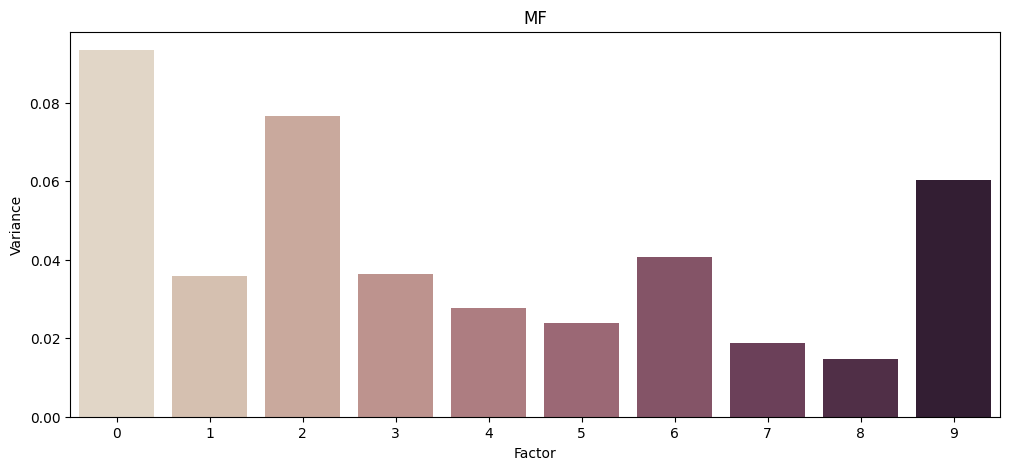

In [21]:
var_df = pd.DataFrame(
    {"Factor": np.arange(K), "Variance": np.var(mf.i_factors, axis=0)}
)
fig, ax = plt.subplots(figsize=(12, 5))
plt.title("MF")
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);

In [22]:
# Download some information of MovieLens 100K dataset
item_df = (
    pd.read_csv(
        cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.item"),
        sep="|",
        encoding="ISO-8859-1",
        names=[
            "ItemID",
            "Title",
            "Release Date",
            "Video Release Date",
            "IMDb URL",
            "unknown",
            "Action",
            "Adventure",
            "Animation",
            "Children's",
            "Comedy",
            "Crime",
            "Documentary",
            "Drama",
            "Fantasy",
            "Film-Noir",
            "Horror",
            "Musical",
            "Mystery",
            "Romance",
            "Sci-Fi",
            "Thriller",
            "War",
            "Western",
        ],
    )
    .set_index("ItemID")
    .drop(columns=["Video Release Date", "IMDb URL", "unknown"])
)

Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.item
will be cached into /Users/ytobio/.cornac/u.item


0.00B [00:00, ?B/s]

File cached!


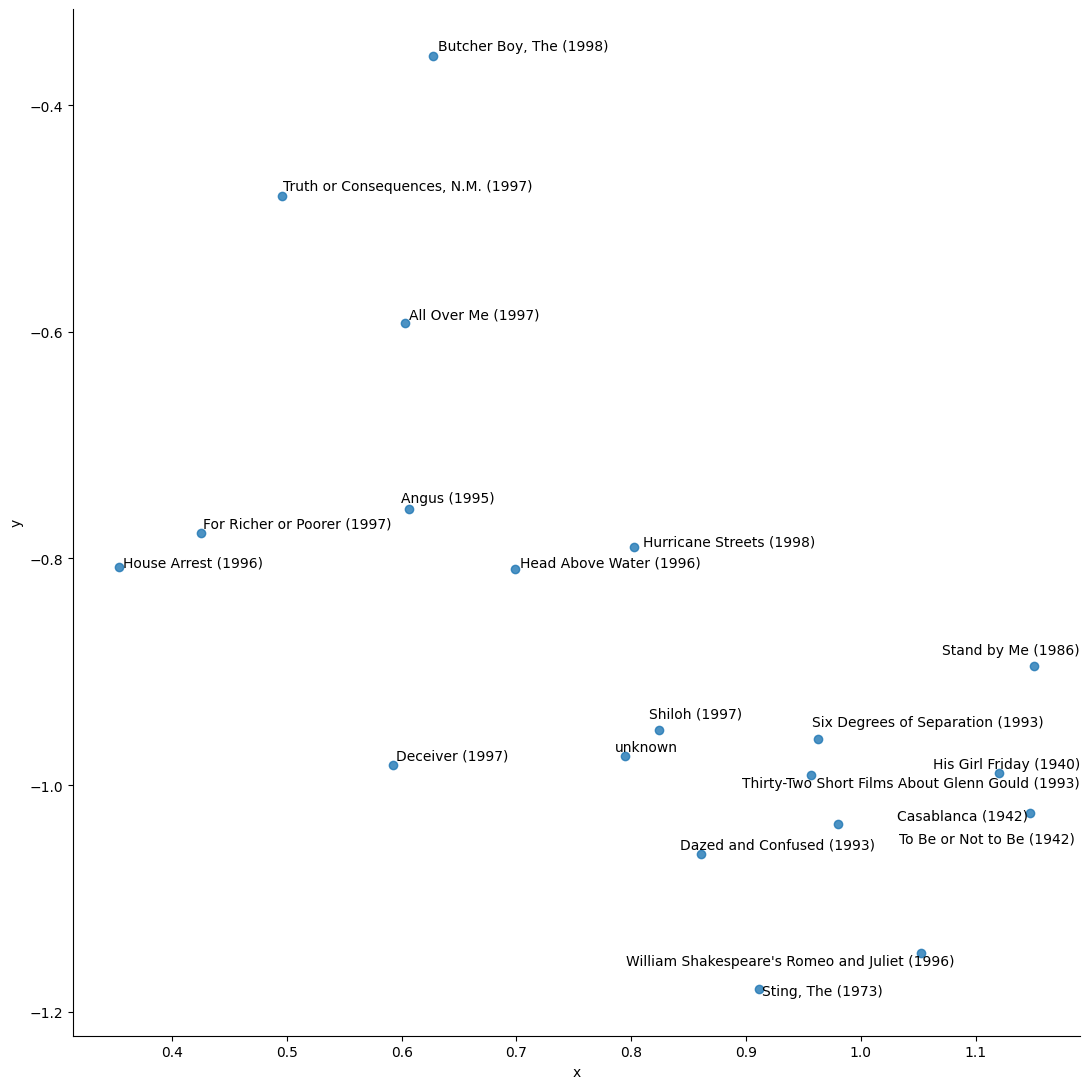

In [23]:
TOP2F = (0, 2)
SAMPLE_SIZE = 20

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(
    np.arange(mf.i_factors.shape[0]), size=SAMPLE_SIZE, replace=False
)
sample_df = pd.DataFrame(data=mf.i_factors[sample_inds][:, TOP2F], columns=["x", "y"])

sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
item_idx2id = list(mf.train_set.item_ids)
titles = item_df.loc[[int(item_idx2id[i]) for i in sample_inds]]["Title"].values
adjust_text(
    [plt.text(*sample_df.loc[i].values, titles[i], size=10) for i in range(len(titles))]
);

### **4.2.3 Non-Negative Matrix Factorization (NMF)**

A variant of matrix factorization is non-negative matrix factorization. In this case the latent factors are constrained to be non-negative.  
This allows for better interpretability as we can reason with positive values.

In [24]:
nmf = NMF(k=1, max_iter=100, learning_rate=0.01, lambda_reg=0.0, verbose=VERBOSE).fit(
    dataset
)
# print("User factors:\n", nmf.u_factors)
# print("Item factors:\n", nmf.i_factors)

recon_R = np.empty(dataset.matrix.shape)
for u, i in itertools.product(range(recon_R.shape[0]), range(recon_R.shape[1])):
    recon_R[u, i] = nmf.score(u, i)

rmse = np.sqrt((((R - recon_R) ** 2) * R_mask).mean())
print(f"\nRMSE = {rmse:.3f}")
print("Reconstructed matrix:")
pd.DataFrame(
    recon_R.round(2),
    index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
    columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)],
)


RMSE = 0.922
Reconstructed matrix:


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,5.76,6.17,5.96,4.05,4.22,4.50
User 2,5.27,5.65,5.46,3.71,3.87,4.12
User 3,2.21,2.36,2.28,1.55,1.62,1.73
User 4,2.41,2.58,2.49,1.69,1.76,1.88
User 5,1.99,2.13,2.06,1.40,1.46,1.55


### NMF on MovieLens 100K

In [25]:
K = 10
nmf = NMF(
    k=K,
    max_iter=200,
    learning_rate=0.01,
    lambda_reg=0.01,
    use_bias=False,
    verbose=VERBOSE,
    seed=SEED,
    name=f"NMF(K={K})",
)

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[nmf], metrics=[rmse]).run()


TEST:
...
          |   RMSE | Train (s) | Test (s)
--------- + ------ + --------- + --------
NMF(K=10) | 1.0196 |    0.3330 |   0.1346




To gain a sense of the inner workings of matrix factorization techniques, let us see how the latent factors could give us some information about how items are associated with one another, as well as which items tend to be associated with a particular factor.

In [26]:
# Download some information of MovieLens 100K dataset
item_df = (
    pd.read_csv(
        cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.item"),
        sep="|",
        encoding="ISO-8859-1",
        names=[
            "ItemID",
            "Title",
            "Release Date",
            "Video Release Date",
            "IMDb URL",
            "unknown",
            "Action",
            "Adventure",
            "Animation",
            "Children's",
            "Comedy",
            "Crime",
            "Documentary",
            "Drama",
            "Fantasy",
            "Film-Noir",
            "Horror",
            "Musical",
            "Mystery",
            "Romance",
            "Sci-Fi",
            "Thriller",
            "War",
            "Western",
        ],
    )
    .set_index("ItemID")
    .drop(columns=["Video Release Date", "IMDb URL", "unknown"])
)

In [27]:
item_df.columns

Index(['Title', 'Release Date', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western'],
      dtype='object')

Let's retrain two models MF and NMF with 10 latent factors and compare their RMSE.  Is there any difference?

In [28]:
K = 10
mf = MF(
    k=K,
    max_iter=20,
    learning_rate=0.01,
    lambda_reg=0.01,
    use_bias=False,
    verbose=VERBOSE,
    seed=SEED,
    name=f"MF(K={K})",
)
nmf = NMF(
    k=K,
    max_iter=200,
    learning_rate=0.01,
    lambda_reg=0.01,
    use_bias=False,
    verbose=VERBOSE,
    seed=SEED,
    name=f"NMF(K={K})",
)

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[mf, nmf], metrics=[rmse]).run()


TEST:
...
          |   RMSE | Train (s) | Test (s)
--------- + ------ + --------- + --------
MF(K=10)  | 0.9027 |    0.0133 |   0.1349
NMF(K=10) | 1.0196 |    0.3333 |   0.1350



### MF

Below is the variance of each latent dimension across different items.  If a factor or dimension has higher variance, it is better at discriminating among different items.  Conversely, if the variance of a factor is too small, it implies that most items would have a similar value for that factor.

/var/folders/hs/d248yjt91hj682bsqhd1bv0m0000gn/T/ipykernel_53213/3875154641.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);


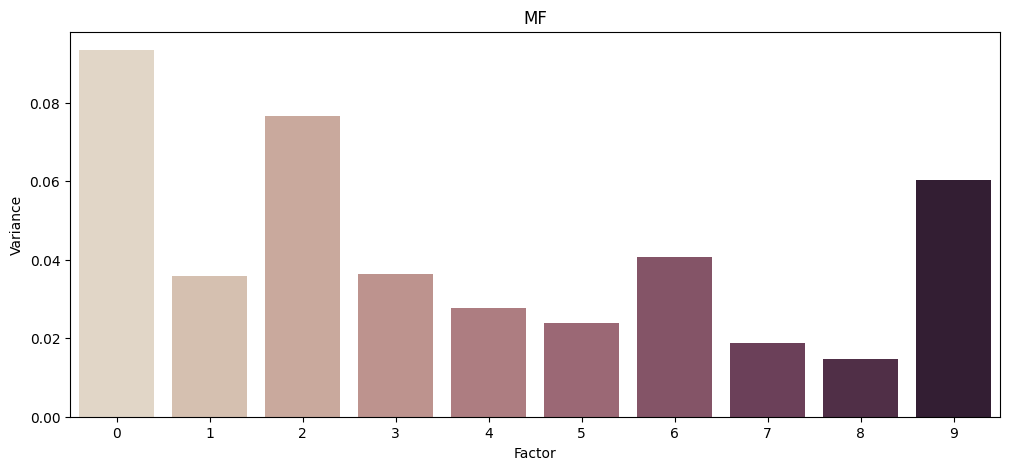

In [29]:
var_df = pd.DataFrame(
    {"Factor": np.arange(K), "Variance": np.var(mf.i_factors, axis=0)}
)
fig, ax = plt.subplots(figsize=(12, 5))
plt.title("MF")
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);

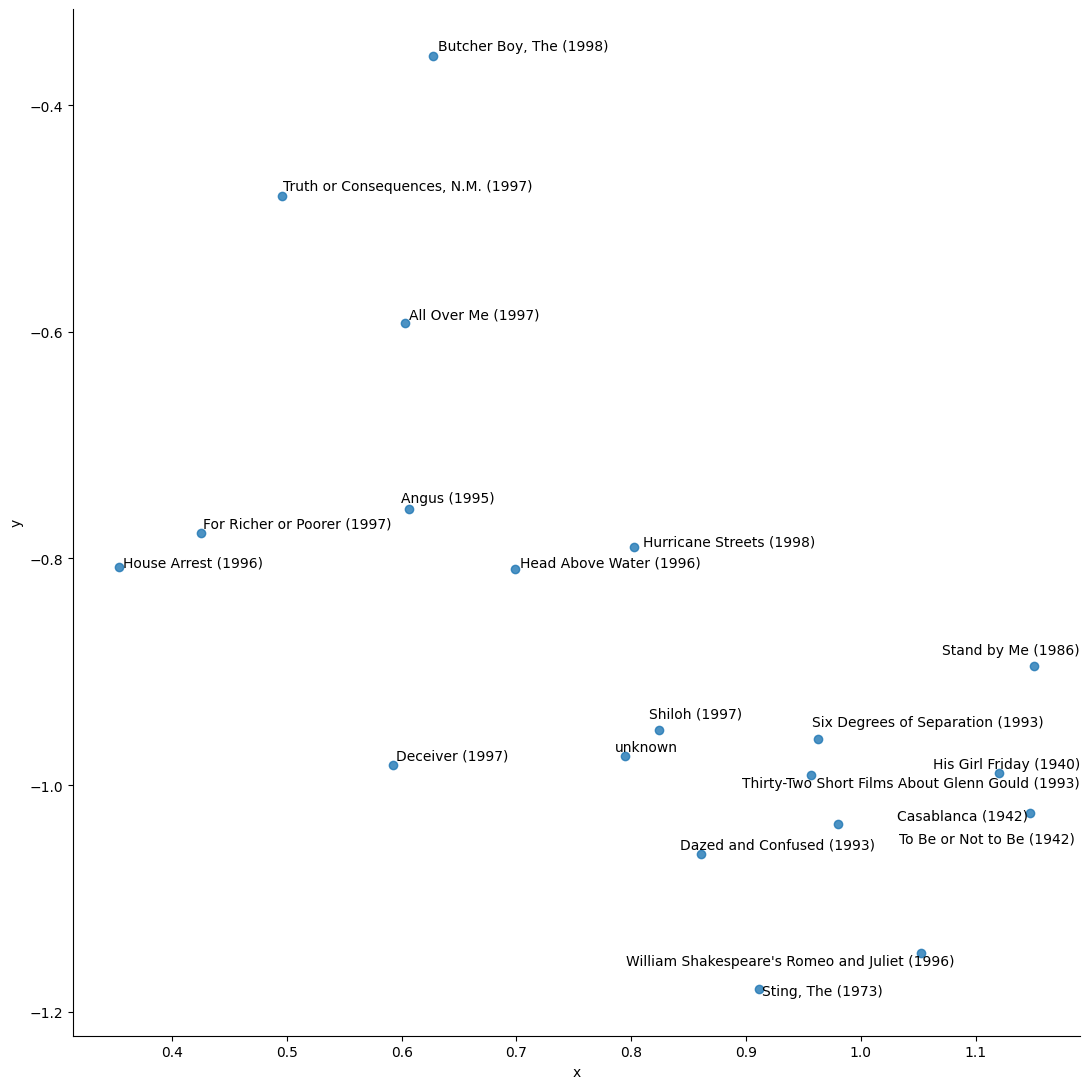

In [30]:
TOP2F = (0, 2)
SAMPLE_SIZE = 20

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(
    np.arange(mf.i_factors.shape[0]), size=SAMPLE_SIZE, replace=False
)
sample_df = pd.DataFrame(data=mf.i_factors[sample_inds][:, TOP2F], columns=["x", "y"])

sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
item_idx2id = list(mf.train_set.item_ids)
titles = item_df.loc[[int(item_idx2id[i]) for i in sample_inds]]["Title"].values
adjust_text(
    [plt.text(*sample_df.loc[i].values, titles[i], size=10) for i in range(len(titles))]
);

### NMF

Below is the variance of each latent dimension.

/var/folders/hs/d248yjt91hj682bsqhd1bv0m0000gn/T/ipykernel_53213/3726567848.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);


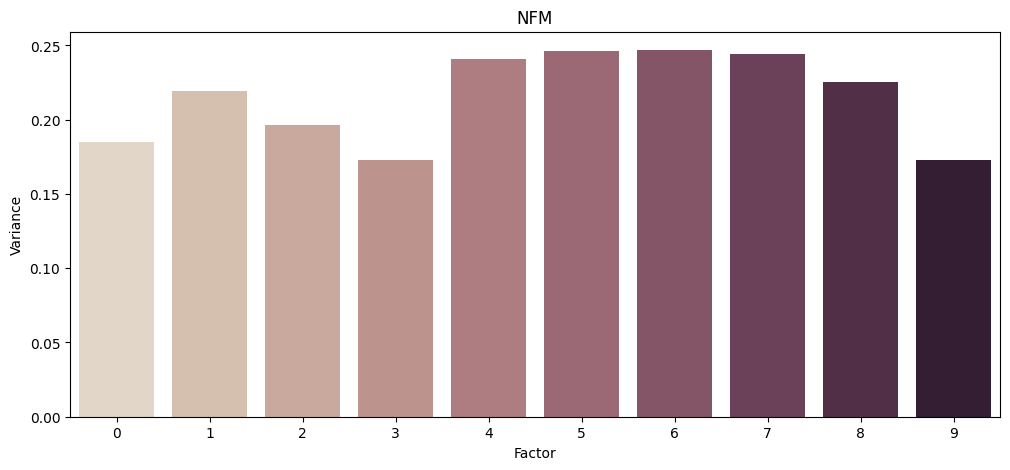

In [31]:
var_df = pd.DataFrame(
    {"Factor": np.arange(K), "Variance": np.var(nmf.i_factors, axis=0)}
)
fig, ax = plt.subplots(figsize=(12, 5))
plt.title("NFM")
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);

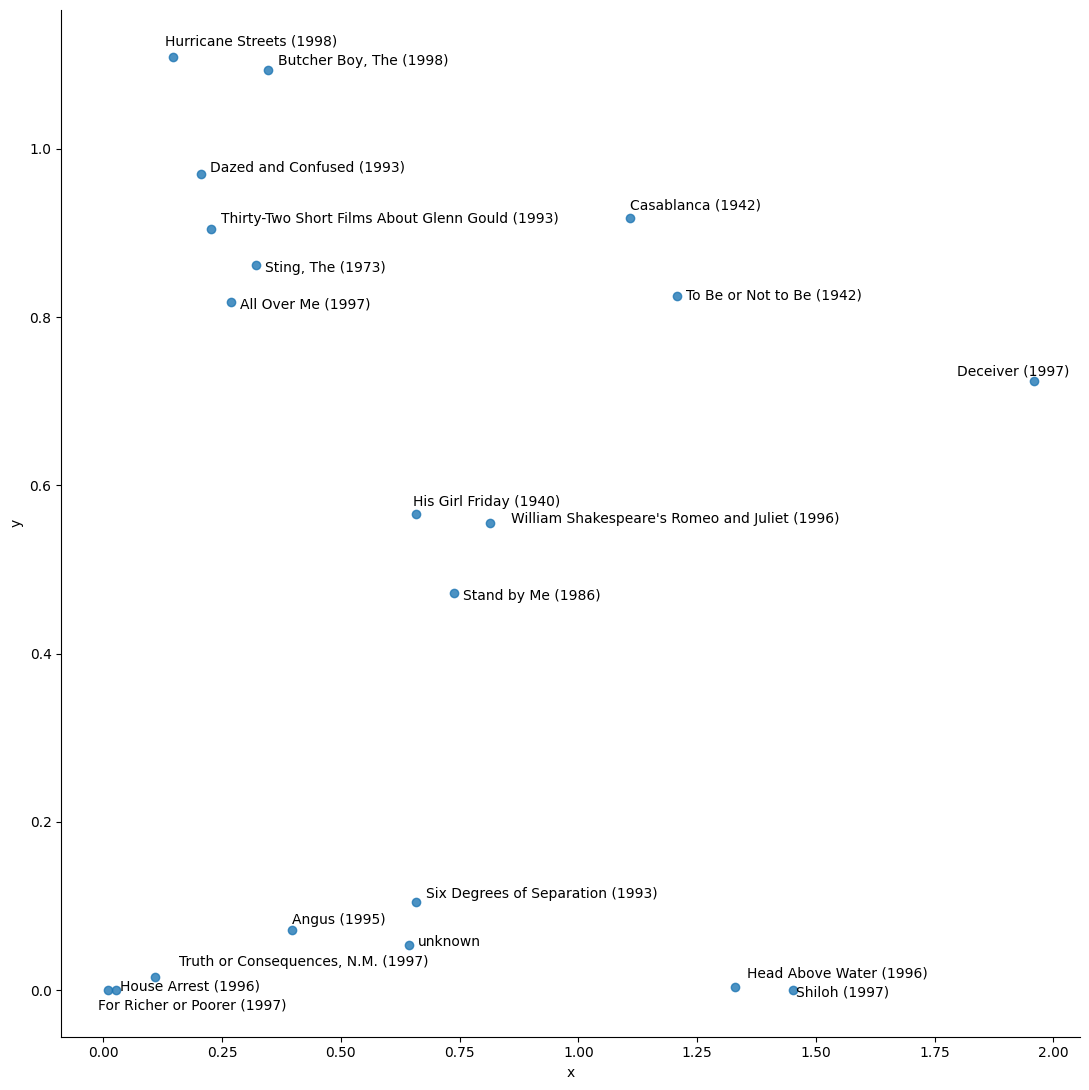

In [32]:
TOP2F = (5, 6)
SAMPLE_SIZE = 20

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(
    np.arange(nmf.i_factors.shape[0]), size=SAMPLE_SIZE, replace=False
)
sample_df = pd.DataFrame(data=nmf.i_factors[sample_inds][:, TOP2F], columns=["x", "y"])

sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
item_idx2id = list(nmf.train_set.item_ids)
titles = item_df.loc[[int(item_idx2id[i]) for i in sample_inds]]["Title"].values
adjust_text(
    [plt.text(*sample_df.loc[i].values, titles[i], size=10) for i in range(len(titles))]
);

Let's see what are the top movies (i.e., highest values) of each latent dimension.

In [33]:
item_idx2id = list(nmf.train_set.item_ids)
top_items = {}
for k in range(K):
    top_inds = np.argsort(nmf.i_factors[:, k])[-5:][::-1]
    top_items[f"Factor {k}"] = item_df.loc[[int(item_idx2id[i]) for i in top_inds]][
        "Title"
    ].values
pd.DataFrame(top_items)

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
0,Carpool (1996),Best Men (1997),Bhaji on the Beach (1993),"Garden of Finzi-Contini, The (Giardino dei Fin...",Tough and Deadly (1995),"Boys, Les (1997)",Ruby in Paradise (1993),Deep Rising (1998),City of Industry (1997),Gumby: The Movie (1995)
1,"Good Man in Africa, A (1994)",Paradise Lost: The Child Murders at Robin Hood...,Panther (1995),Kissed (1996),8 Heads in a Duffel Bag (1997),Nénette et Boni (1996),Mina Tannenbaum (1994),Captives (1994),Romper Stomper (1992),Turbulence (1997)
2,"Neon Bible, The (1995)",Angel Baby (1995),Nina Takes a Lover (1994),"Ice Storm, The (1997)",Selena (1997),Ghost in the Shell (Kokaku kidotai) (1995),Harlem (1993),"Baby-Sitters Club, The (1995)",Tetsuo II: Body Hammer (1992),"Man in the Iron Mask, The (1998)"
3,C'est arrivé près de chez vous (1992),Cemetery Man (Dellamorte Dellamore) (1994),Cats Don't Dance (1997),"Low Down Dirty Shame, A (1994)",Love Jones (1997),Grace of My Heart (1996),"Secret Agent, The (1996)",Prisoner of the Mountains (Kavkazsky Plennik) ...,"Boys, Les (1997)",Radioland Murders (1994)
4,Miami Rhapsody (1995),Underground (1995),Until the End of the World (Bis ans Ende der W...,Dunston Checks In (1996),"Little Princess, The (1939)",Stalingrad (1993),"White Balloon, The (1995)",Guilty as Sin (1993),To Live (Huozhe) (1994),Infinity (1996)


For each latent factor, we take the top 100 movies with the highest values for that factor.  We then bin them into their respective genres. This hints at whether there is a relationship or association between latent factors and movie genres.

In [34]:
item_idx2id = list(nmf.train_set.item_ids)
top_genres = {}
for k in range(K):
    top_inds = np.argsort(nmf.i_factors[:, k])[-100:]
    top_items = item_df.loc[[int(item_idx2id[i]) for i in top_inds]]
    top_genres[f"Factor {k}"] = top_items.drop(columns=["Title", "Release Date"]).sum(
        axis=0
    )
pd.DataFrame(top_genres)

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
Action,18,11,12,17,12,7,4,5,20,15
Adventure,12,4,11,3,5,3,6,2,13,11
Animation,0,1,1,5,3,2,5,0,0,3
Children's,5,3,6,5,5,5,2,2,8,20
Comedy,27,29,31,36,22,32,33,28,24,38
Crime,7,9,5,9,4,3,6,4,9,3
Documentary,3,10,1,3,1,6,4,3,2,3
Drama,39,42,45,43,49,50,55,60,45,30
Fantasy,0,1,1,0,1,1,0,0,1,2
Film-Noir,1,0,0,3,2,1,0,1,0,1


## References

1.   Aggarwal, C. C. (2016). Recommender systems (Vol. 1). Cham: Springer International Publishing.
2.   Koren, Y., Bell, R., & Volinsky, C. (2009). Matrix factorization techniques for recommender systems. Computer, 42(8), 30-37.
3.   Lee, D. D., & Seung, H. S. (2001). Algorithms for non-negative matrix factorization. In Advances in neural information processing systems (pp. 556-562).